# Защита персональных данных клиентов

Нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных,чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

### Описание данных

     Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
     Целевой признак: количество страховых выплат клиенту за последние 5 лет.

## Импортируем библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Модели

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
import numpy as np
import itertools 
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from functools import reduce   
from scipy import stats as st
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy.random import RandomState


## Загрузка данных

In [2]:
try:
    data = pd.read_csv('/datasets/insurance.csv')

except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')


In [3]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


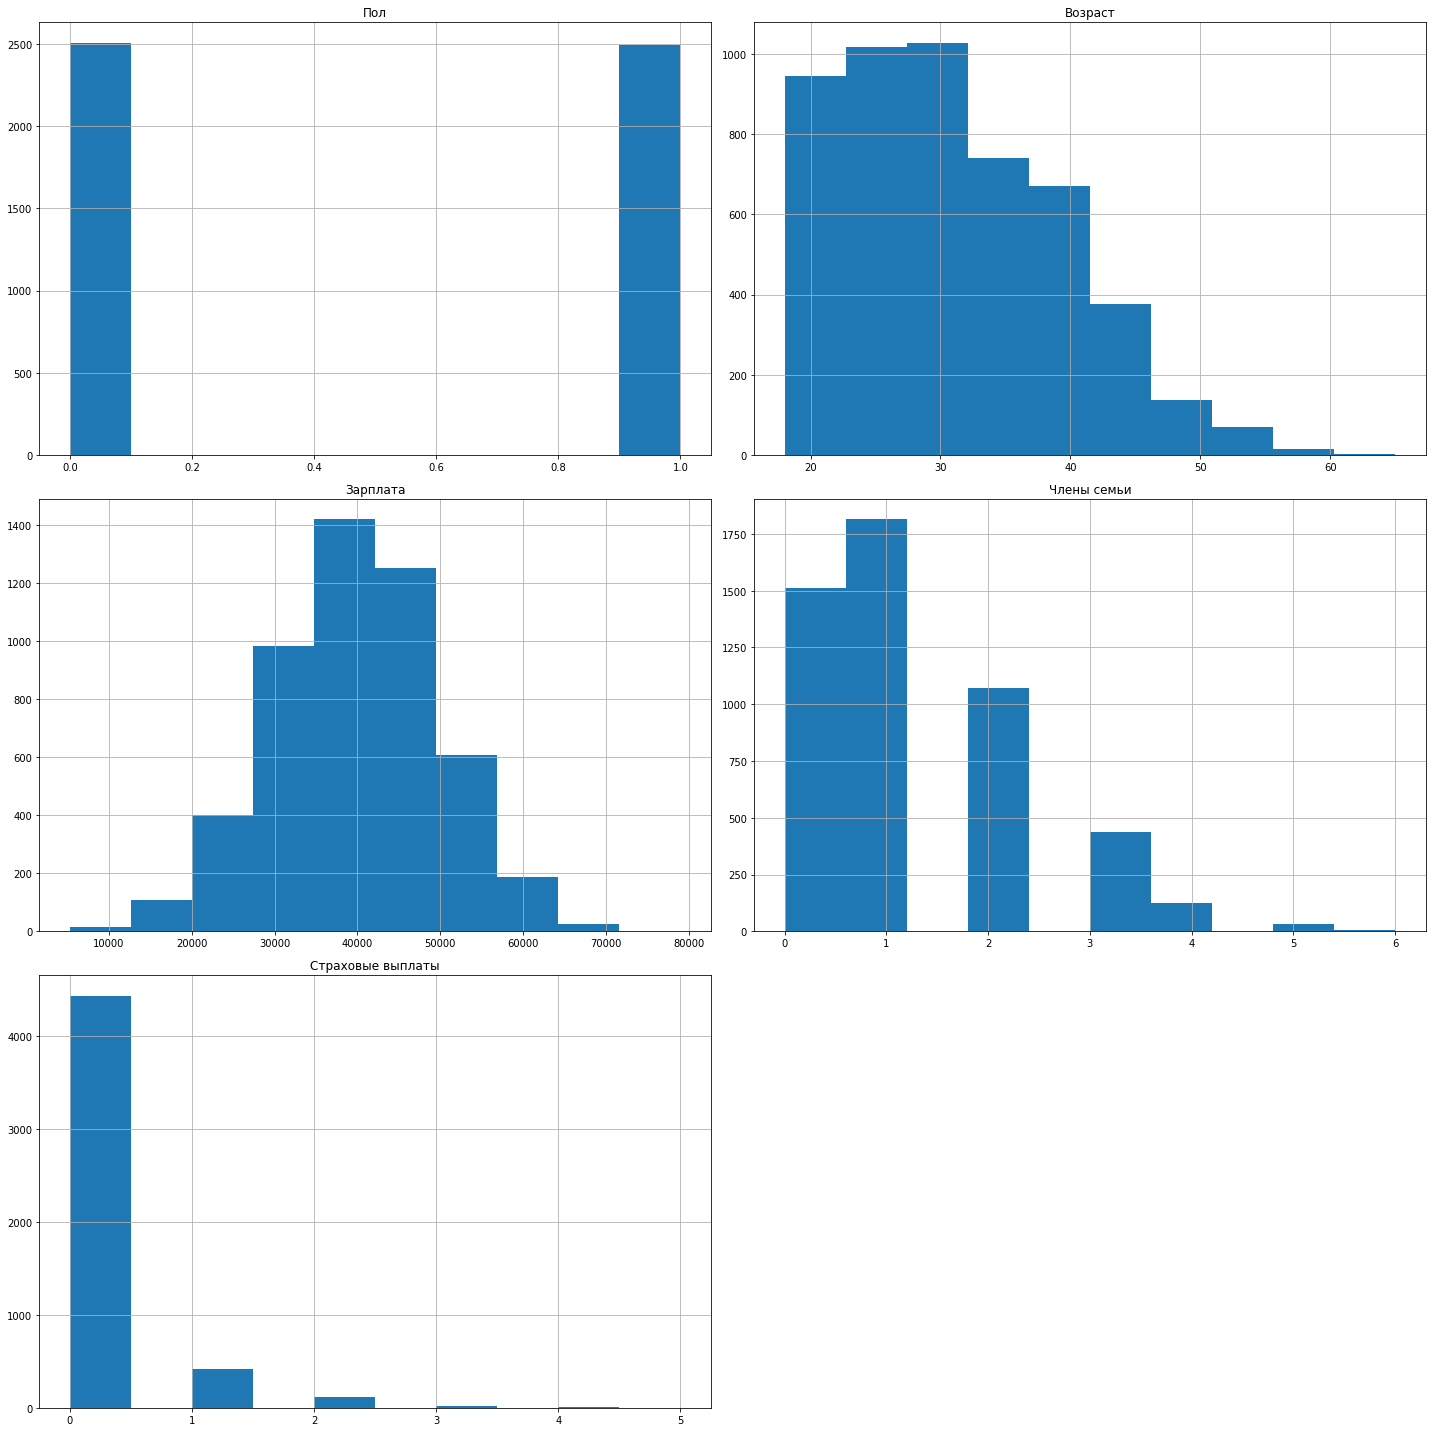

In [6]:
data.hist(figsize=(20, 20))
plt.tight_layout() 

In [7]:
data.duplicated().sum() # Дубликаты

153

In [8]:
data.isnull().sum() # Пропуски

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

### Стиль загаловков

In [9]:
data = data.rename(columns=str.lower)

In [10]:
data.columns

Index(['пол', 'возраст', 'зарплата', 'члены семьи', 'страховые выплаты'], dtype='object')

In [11]:
data = data.rename(columns={'пол' : 'sex', 'возраст' : 'age', 'зарплата' : 'income', 'члены семьи' : 'family_size', 
                            'страховые выплаты' : 'insurance_payments'})

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_size         5000 non-null   int64  
 4   insurance_payments  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


### График корреляции

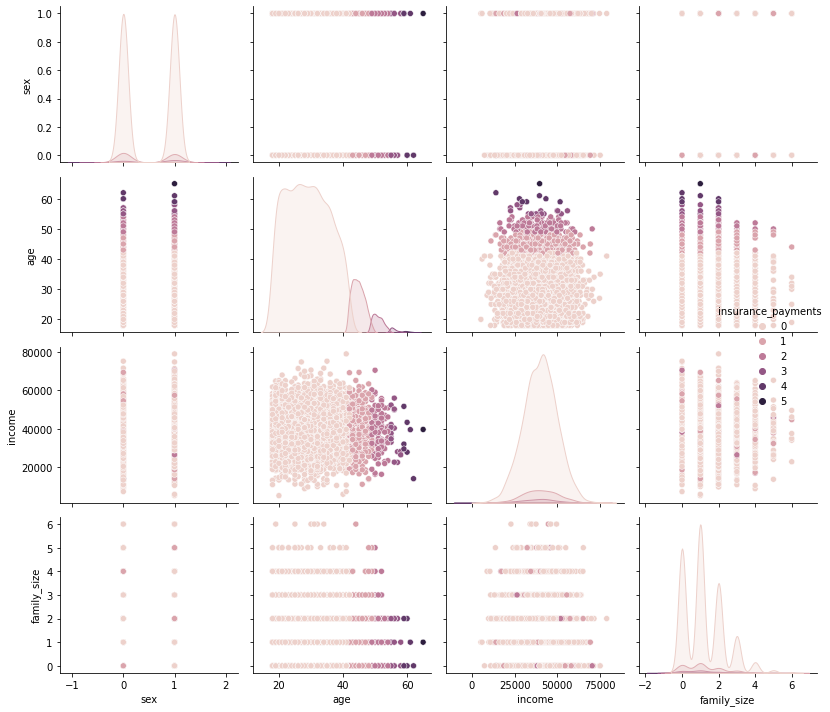

In [13]:
sns.pairplot(data, hue='insurance_payments')
plt.tight_layout() # убираем служебную информацию

**Выводы**
- Колонки были переиминованы для удобства
- Учитывая отсутствие индивидуальных идентификаторов и не большое количество дубликатов предлагаю их не удалять
- Можно приступать к основной части проекта

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?


**Предположение:** Не изменится

#### Доказательство


1. Матрица признаков $Xnew$ это произведение  $X$ на матрицу на обратимую матрицу $P$ :

$$
Xnew = X * P
$$

2. Подставим новое значение $Xnew$ в формулу $w1$:

$$
w new = ((X P)^T X P)^{-1} (X P)^T y
$$

3. Раскроем первое произведение:

$$
w new = (P^T X^T X P)^{-1} P^T X^T y
$$

4. Переобразуем множители в скобках, в произведение трех множителей:

$$
w new = (P^T (X^T X) P)^{-1} P^T X^T y
$$

5. Раскроем скобки $ (P^T (X^T X) P)^{-1} $:

$$
w new = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

6. Так как $P$ обратимая, то произведение $(P^T)^{-1} P^T$ равно единичной матрице $E$:

$$
w new = P^{-1} (X^T X)^{-1} E X^T y = P^{-1} (X^T X)^{-1} X^T y
$$


7. Подставим новое значение весов  $𝑤 new $  в формулу для предсказаний линейной регрессии.
   Предсказания модели расчитываются по формуле:

$$
a = Xw
$$

8. Подставим в эту формулу значения $X new$ и $w new$ для того, чтобы предсказания модели $a new$:

$$
a new = Xnew * w new = XPP^{-1} w
$$

9. Так как $P$ по условию обратимая, то произведение $PP^{-1}$ снова равно $E$:

$$
a new = XPP^{-1} w = X E w = X w = a
$$

10. Мы доказали, что предсказания $a new$ для матрицы признаков, умноженных на обратимую матрицу $P$ равны предсказаниям $a$. Параметры линейной регрессии в исходной задаче и в преобразованной связаны следующим образом<br>

$$
w new = P^{-1} w
$$

**Вывод:**:
При умножении признаков на обратимую матрицу, предсказания модели не поменяется

## Алгоритм преобразования

Чтобы защитить данные и потерять качество модели машинного обучения, нужно умножить признаки на обратимую матрицу $P$. Ниже обоснуем алгоритм.


###  Разобьем данные на выборки

In [14]:
features = data.drop('insurance_payments', axis = 1)
target = data['insurance_payments']

In [15]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sex          5000 non-null   int64  
 1   age          5000 non-null   float64
 2   income       5000 non-null   float64
 3   family_size  5000 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 156.4 KB


In [16]:
#target.info()

### Создалим матрицу

In [17]:
matrix = np.random.randint(100,size = (4, 4)) # размерность по количеству признаков

In [18]:
matrix

array([[24, 89, 88, 95],
       [17, 92, 58, 18],
       [10, 94, 29, 90],
       [ 7, 17, 50, 37]])

### Инвертируем матрицу

In [19]:
matrix_inverted = np.linalg.inv(matrix)

In [20]:
matrix_inverted

array([[ 0.14955076, -0.03256297, -0.07703598, -0.18075543],
       [-0.01604902,  0.01321532,  0.01180144,  0.00607167],
       [-0.02046883,  0.00998244,  0.00175622,  0.04342691],
       [ 0.00674107, -0.01340112,  0.00677883, -0.00025071]])

### Расчитаем  $w$ для  признаков

In [21]:
w = np.linalg.inv(features.T.dot(features)).dot(features.T).dot(target)

In [22]:
w

array([-4.43854686e-02,  2.33356224e-02, -1.17739038e-05, -4.55168125e-02])

### Расчитаем  $a$

In [23]:
a = features @ w

In [24]:
a

0       0.282873
1       0.580513
2       0.429481
3      -0.091957
4       0.301713
          ...   
4995    0.142035
4996    0.130942
4997   -0.023457
4998   -0.052559
4999    0.085475
Length: 5000, dtype: float64

### Умножим features на матрицу

In [25]:
features_p = features @ matrix

In [26]:
features_p

,0,1,2,3
0,496728.0,4666278.0,1440916.0,4464870.0
1,380789.0,3576249.0,1104718.0,3420865.0
2,210493.0,1976668.0,610682.0,1890522.0
3,417371.0,3921766.0,1210618.0,3753452.0
4,261500.0,2456065.0,758612.0,2349599.0
...,...,...,...,...
4995,357490.0,3358410.0,1037024.0,3213578.0
4996,524585.0,4928745.0,1521622.0,4716649.0
4997,339354.0,3188474.0,984360.0,3051434.0
4998,327419.0,3075964.0,949814.0,2943602.0


### Расчитаем  𝑤_new

In [27]:
w_new = np.linalg.inv(features_p.T.dot(features_p)).dot(features_p.T).dot(target)

In [28]:
w_new

array([ 0.00082416,  0.00074488, -0.00083428, -0.00060087])

### Расчитаем a_new

In [29]:
a_new = features_p @ w_new

In [30]:
a_new

0       0.282857
1       0.580537
2       0.429493
3      -0.091938
4       0.301687
          ...   
4995    0.142056
4996    0.130964
4997   -0.023439
4998   -0.052578
4999    0.085453
Length: 5000, dtype: float64

### Убедимся, что разница минимальна

In [31]:
d = a - a_new

In [32]:
d.sum()

0.0006750035327833595

**Вывод** Сумма разниц крайне мала. Качество модели при обучении не ухудшится.

## Проверка алгоритма

### Обучим Модель на исходных данных

In [33]:
model = LinearRegression()
model.fit(features, target)
preds = model.predict(features)


In [34]:
r2_score(target, preds)

0.4249455028666802

### Обучим Модель на шифрованых данных

In [35]:
features_enc = features @ matrix
model.fit(features_enc, target)
enc_preds = model.predict(features_enc)

In [36]:
r2_score(target, enc_preds)

0.4249455028666801

**Вывод** Показатели метрик до и после шифрования крайне близки. Шифрования не меняет данные ощутимо. его можно использовать

## Общий вывод

- В ходе проекта удалось выяснить, что при умножении на обратимую матрицу качество модели ошутимо не изменяется. Подобный метод шифрования можно применять. 
- Для доказательства верности подхлда понадобилось использовать базовые знания линейной алгебры
- Для дальнейшего обоснования верности выбранного подхода была посчитана разница между предсказаниями до и после преобразования.
- Так же был произведен минимальный необходимый анализ данных, были переименованны названия признаков для приведения их к общепринятому виду и удобства написания кода.